In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade
import time

In [2]:
# setting the work to be done in single precision
tf.keras.backend.set_floatx("float64")

## The Network 

### Hidden Layers
The model I've made has a structure of 8 hidden layers with 20 nodes in each layer. The activation function used is $tanh$.

### Loss Function
We define our loss function as the mean squared error of our differential equation moved to one side of the equation and of our boundary data. For the Burgers' equation (see below), our loss function is

$$
L = \frac1N \sum \limits_{i=1}^{N} (\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - D \frac{\partial^2 u}{\partial x^2})^2 + \frac1M \sum \limits_{j=1}^{M} (u_{model} - u_{boundary})^2
$$

where $u_{model}$ is the output of the model with boundary inputs (either $t=0$ or $x=\pm 1$) and $u_{boundary}$ is the desired/correct boundary (including initial) conditions.

### Optimizer

The optimizer I use here is the Adam (Adaptive Moment Optimization) optimizer. The Adam optimier is a ***Batched Stocastic Gradient Descent*** model that uses ***Momentum*** in it's gradient calculation and ***RMSProp*** in its adaptive learning rate (step size of the Euler-style weight training).

[Here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/) is a comprehensive overview on Optimizers that works ground up to Adam.

#### Stochastic Batched Gradient Descent

The simple model (just Gradient Descent) of training a Neural Network (NN) over an epoch the following steps.



1.   Find the average loss, $L$, over all of the training data
2.   Calculate the gradient of $L$ with respect to the weights, $w_{ij}$
3.   With some learning rate, $\alpha$, train the weights by 

$$
w_{new} = w_{old} - \alpha \frac{\partial L}{\partial w_{ij}}  
$$

This method tends to work fine for convex loss landscapes, but not for nonconvex landscapes as it is unclear of how far you need to go before you find the concavity of a minima. The first step to fix this was to train on the loss of each piece of training data individually, rather than the training set as a whole. This is known as ***Stocastic Gradient Descent.*** (SGD) However, this method tends to be very "bouncy" in the loss landscape, making it hard to settle at a minimum. This was remedied by introducing ***Batched Stocastic Gradient Descent*** (BSGD) where rather than training on all of the training data at once, or just one of the training data, we train on batches/subsets of training data. Interestingly, SGD actually approches the minima faster than BSGD but has convergence issues when it's close to a minima due to being bouncy.


#### Momentum

Gradient descent and it's variants all share the common issue of finding a local minima and staying there. To solve this, the idea of adding momentum to the gradients came about. Essentially, this takes the gradients and averages them with the gradients from previous training data/batches in (B)SGD to make a sort of "moving average" of the gradient. If we think of these previous training batches as previous discrete time intervals, we can formalize this process as

$$
\delta_t = (1-\beta_1)  \alpha \frac{\partial L}{\partial w_t} + \beta_1 \delta_{t-1}
$$
$$
w_{t} = w_{t-1} - \delta_t
$$

where $\beta$ is the "momentum" that specifies how many gradients into the past we go. For example, $\beta = 0.9$ would take into account the last 10 gradients including


#### RMSProp

RMSProp is a kind of momentum that we now apply to the learning rate, $\alpha$ to make it adaptive. The main difference here is that, instead of being a moving average of the gradients, it is a moving average of the inverse of the curvature of the loss function with respect to the weights. **In simpler words, "if the curvature of the loss landscape is high, learn slower."** We formalize this process below.

$$
v_t = (1 - \beta_2)\frac{\partial^2 L}{(\partial w_t)^2} + \beta_2 v_{t-1}
$$

$$
w_t = w_{t-1} - \frac{\alpha}{\sqrt{v_t}} \frac{\partial L}{\partial w_t}
$$

Where $\beta_2$ is again our "momentum."

#### Adam
The Adam optimizer combines both Momentum and RMSProp in the optimization process.

## Model

### Burgers' Equation

I've chosen to solve the Burgers' equation as it seems to be one of the canonical examples in the world of PINNs. The equation is a simplified 1D Navier-Stokes equation

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = D \frac{\partial^2 u}{\partial x^2}
$$

where $u(x,t)$ is the 1D speed of a fluid I've set the diffusion constant $D=\frac{0.01}{\pi}$. 

The boundary and initial conditions are 

$$
u(-1,t) = u(1,t) = 0 ;\space  u(x,0) = -\sin(\pi x)
$$

To solve numerically using the Finite Difference Method (FDM), we can turn it into

$$
\frac{u(i,j+1) - u(i,j)}{dt} + u(i,j)\frac{u(i+1,j) -u(i-1,j)}{2dx} = D \frac{u(i+1,n) + u(i-1,n) - 2u(i+1,n)}{dx^2}
$$

which after rearranging and setting $r=\frac{dt}{dx}$, yields

$$
u(i,j+1) = u(i,j) - r \space u(i,j) \bigg[\frac{u(i+1,j)  - u(i-1,j)}{2}\bigg] + D\frac {r}{dx} \bigg[u(i+1,n) + u(i-1,n) - 2u(i+1,n)\bigg]
$$

Note that I used the average of the derivative on either side for the $\frac{\partial u}{\partial x}$ term so as to not give any bias to left or righthand derivatives.


## Machinery

In [93]:


class PINN() :

  tTrainMaxCo = 1
  tTrainMaxBD = 1
  
  epochs = 2000
  y_d = None
  x_d = None
  t_d = None
  t_c = None
  x_c = None
  model = None
  loss_list = None

  
    # the physics informed loss function used for collocation points
  @tf.function
  def f(self,t, x):
      u0 = self.u(t, x)
      u_t = tf.gradients(u0, t)[0]
      u_x = tf.gradients(u0, x)[0]
      u_xx = tf.gradients(u_x, x)[0]
      F = u_t + u0*u_x - (0.01/np.pi)*u_xx
      return tf.reduce_mean(tf.square(F))

  # MSE loss function used for data points
  @tf.function
  def mse(self,y, y_):
      return tf.reduce_mean(tf.square(y-y_))

  # u(t, x) just makes working with model easier and the whole code looks more
  # like its mathematical backend
  @tf.function
  def u(self, t, x):
      # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
      # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
      # is build by simply concatenation of (t, x)
      u = self.model(tf.concat([t, x], axis=1)) # note the axis ; `column`
      return u
  

  def prepData(self,Nc = 10000) :
    self.buildBoundaryData()
    self.buildColloData(Nc=Nc)
    self.dataToTensor()
    

  def buildBoundaryData(self) :
    ## data generation
    number_of_ic_points = 50
    number_of_bc1_points = 25
    number_of_bc2_points = 25

    t_i = np.zeros((number_of_ic_points,1))
    x_i = np.random.random((number_of_ic_points,1))*2 - 1 #random numbers in the x domain [-1,1)

    x_bN1 = -1*np.ones((number_of_bc1_points,1)) #left boundary
    x_bP1 = np.ones((number_of_bc2_points,1)) #right boundary

    x_b = np.append(x_bN1,x_bP1,axis=0)
    t_b = self.tTrainMaxBD*np.random.random((number_of_bc1_points + number_of_bc2_points,1)) #random in t domain (0,1]

    self.x_d = np.append(x_i,x_b,axis=0)

    self.t_d = np.append(t_i,t_b,axis=0)

    # output values for data points (boundary and initial)
    self.y_d = np.zeros(self.x_d.shape)

    # for initial condition: IC = -sin(pi*x)
    self.y_d[ : number_of_ic_points] = -np.sin(np.pi * self.x_d[:number_of_ic_points])

    # all boundary conditions are set to zero
    self.y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
    self.y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

  def buildColloData(self, Nc = 10000) :
    # number of collocation points is Nc
    

    # LHS for collocation points
    engine = qmc.LatinHypercube(d=2)
    data = engine.random(n=Nc)
    # set x values between -1. and +1.
    data[:, 1] = 2*(data[:, 1]-0.5)

    # change names
    self.t_c = self.tTrainMaxCo*np.expand_dims(data[:, 0], axis=1)
    self.x_c = np.expand_dims(data[:, 1], axis=1)


  def dataToTensor(self) : 
    self.x_d, self.t_d, self.y_d, self.x_c, self.t_c = map(tf.convert_to_tensor, [self.x_d, self.t_d, self.y_d, self.x_c, self.t_c])


  def buildModel(self) :
    ### model design
    #
    neuron_per_layer = 20
    # activation function for all hidden layers
    actfn = "tanh"

    # input layer
    self.input_layer = tf.keras.layers.Input(shape=(2,))

    # hidden layer
    # also a for loop could be used instead of multiple lines of code
    self.hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.input_layer)
    self.hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden0)
    self.hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden1)
    self.hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden2)
    self.hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden3)
    self.hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden4)
    self.hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden5)
    self.hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden6)
    self.hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(self.hidden7)

    # output layer
    self.output_layer = tf.keras.layers.Dense(1, activation=None)(self.hidden8)

    self.model = tf.keras.Model(self.input_layer, self.output_layer)

    
  def train(self,printLoss=True) :
    self.loss_list = []

    # L-BFGS optimizer was used in the reference paper
    # there is a way to incorporate it using the 
    opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
    start = time.time()

    # training loop
    for epoch in range(self.epochs):
        with tf.GradientTape() as tape:
            # model output/prediction
            y_ = self.u(self.t_d, self.x_d)
            # physics-informed loss for collocation points
            L1 = self.f(self.t_c, self.x_c)
            # MSE loss for data points
            L2 = self.mse(self.y_d, y_)
            loss = L1 + L2
        # compute gradients
        g = tape.gradient(loss, self.model.trainable_weights)
        self.loss_list.append(loss)
        # log every 10 epochs
        if printLoss :
          if (not epoch%10) or (epoch == self.epochs-1):
            print(f"{epoch:4} {loss.numpy():.3f}")
        # apply gradients
        opt.apply_gradients(zip(g, self.model.trainable_weights))

    end = time.time()
    if printLoss :
      print(f"{end - start:.3} (s)")


  def plotTrainLoss(self) :
    plt.semilogy(range(self.epochs), self.loss_list)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Training Loss")

  
  def plotTestResults(self) :
    ### plot
    n, m = 100, 200
    X = np.linspace(-1, +1, m)
    T = np.linspace(0, 1, n)
    X0, T0 = np.meshgrid(X, T)
    X = X0.reshape([n*m, 1])
    T = T0.reshape([n*m, 1])
    X = tf.convert_to_tensor(X)
    T = tf.convert_to_tensor(T)
    X.shape, T.shape
    #plt.figure(figsize=(5, 2), dpi=600)
    S = self.u(T, X)
    S = S.numpy().reshape(n, m)
    plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
    plt.colorbar()
    plt.xlim(0., +1)
    plt.ylim(-1, +1)
    plt.title("u(x, t)")
    plt.ylabel("x")
    plt.xlabel("t")
    plt.scatter(self.t_d, self.x_d, marker="x", c="k")
    plt.show()

class FDM() :

  tRange = 1
  xRange = 2
  xSplit = 10
  tSplit = 10000

  Nx = 2000
  Nt = 1000000
  dx = xRange / Nx
  dt = tRange / Nt
  r = dt/dx
  D = 0.01/np.pi

  
  
  def build(self) :

    self.tSpace = np.linspace(0,self.tRange,self.Nt+1)
    self.xSpace = np.linspace(-1,1,self.Nx+1)
    
    self.u = -1 * np.sin(np.pi*self.xSpace)
    self.u[0] = 0
    self.u[-1] = 0
    self.uNew = np.zeros(self.Nx+1)

    self.boolArr = np.ndarray(self.u.shape, dtype = bool)
    self.boolArr[::self.xSplit] = True

    self.uList = np.zeros((self.Nt//self.tSplit,len(self.u[::self.xSplit])))

    self.xPlotSpace = self.xSpace[::self.xSplit]
    self.tPlotSpace = self.tSpace[::self.tSplit]

    self.tMesh, self.xMesh = np.meshgrid(self.tPlotSpace,self.xPlotSpace)

  def printShapes(self) :
    print("1-1 : ", self.u[1:-1].shape)


  def updateU(self) :
    #self.uNew[1:-1] = self.u[1:-1]  - self.r* self.u[1:-1] *(self.u[1:-1] - self.u[:-2]) + (self.D*self.r/self.dx)*(self.u[2:] + self.u[0:-2] - 2*self.u[1:-1])
    
    self.uNew[1:-1] = self.u[1:-1]  - self.r* self.u[1:-1] * 1/2 *(self.u[2:] - self.u[:-2]) + (self.D*self.r/self.dx)*(self.u[2:] + self.u[0:-2] - 2*self.u[1:-1])



  def solve(self) :

    self.uList[0] = self.u[::self.xSplit]

    ii = 1

    for t in range(1,self.Nt) :

      
      self.updateU()
      self.u = self.uNew.copy()

      if t % self.tSplit == 0 :

        self.uList[ii] = self.u[::self.xSplit]
        ii += 1
        pass

      #if t % 100 == 0 :
      #  print(f"t :{t}")
      #  print(f"1  :{np.sum(np.average(-1* self.r* self.u[1:-1] *(self.u[1:-1] - self.u[:-2])))}")
      #  print(f"2  :{np.sum(np.average((self.D*self.r/self.dx)*(self.u[2:] + self.u[0:-2] - 2*self.u[1:-1])))}")

  





## Usage and Confirmation

Here, I train the model on the temporal bounds (0,1) and then compare it against solving the Burgers' equation via FDM.

In [ ]:
k1 = PINN()
k1.epochs = 10000
k1.prepData()
k1.buildModel()
k1.train(printLoss=False)

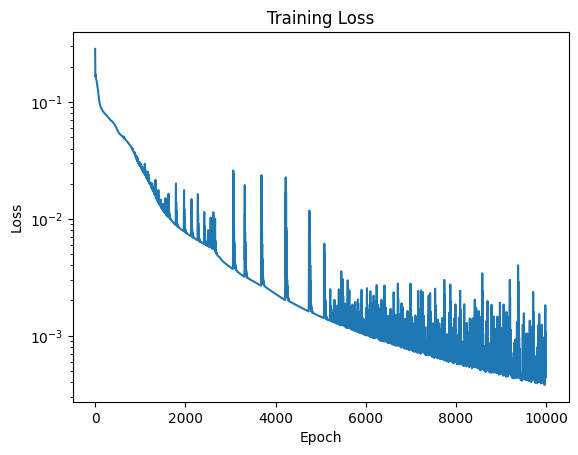

In [82]:
k1.plotTrainLoss()

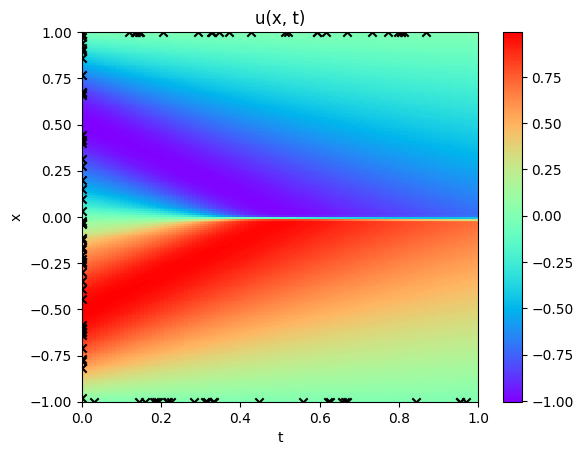

In [83]:
k1.plotTestResults()

To confirm, we check the NN solution against the Finite Difference Method (FDM). 

In [94]:
#Generate FDM data
f = FDM()
f.build()
f.solve()

In [105]:
### getting the data from the network
n, m = len(f.tPlotSpace), len(f.xPlotSpace)
X = f.xPlotSpace
T = f.tPlotSpace
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
S = k1.u(T, X)
S = S.numpy().reshape(n, m)


Text(0.5, 1.0, 't=0.75')

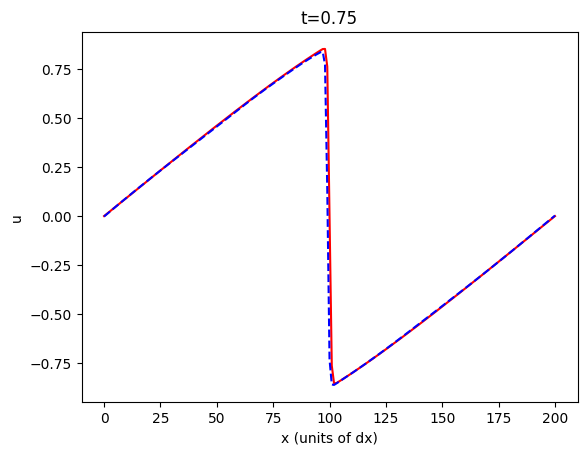

In [104]:
t = 75
plt.plot(f.uList[t], 'r')
plt.plot(S[t], 'b', linestyle = "dashed")
plt.xlabel("x (units of dx)")
plt.ylabel("u")
plt.title(f"t={(t)*0.01}")

Text(0.5, 1.0, 't=0.5')

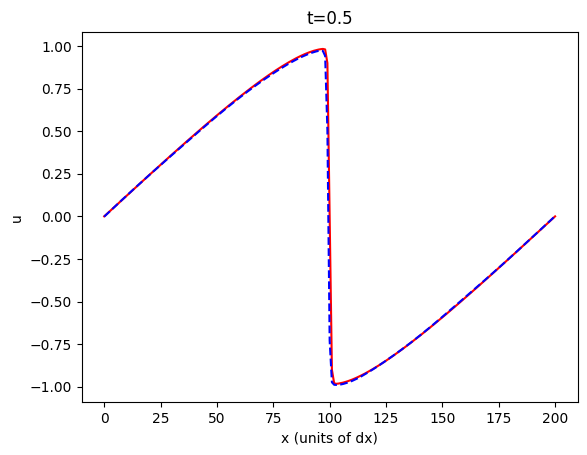

In [106]:
t = 50
plt.plot(f.uList[t], 'r')
plt.plot(S[t], 'b', linestyle = "dashed")
plt.xlabel("x (units of dx)")
plt.ylabel("u")
plt.title(f"t={(t)*0.01}")

Text(0.5, 1.0, 't=0.25')

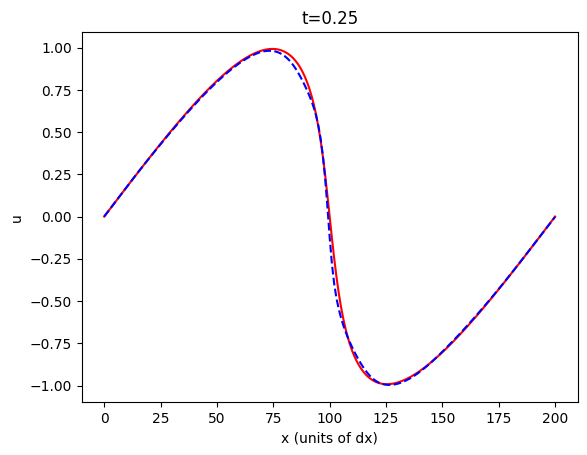

In [107]:
t = 25
plt.plot(f.uList[t], 'r')
plt.plot(S[t], 'b', linestyle = "dashed")
plt.xlabel("x (units of dx)")
plt.ylabel("u")
plt.title(f"t={(t)*0.01}")

Text(0.5, 1.0, 't=0.0')

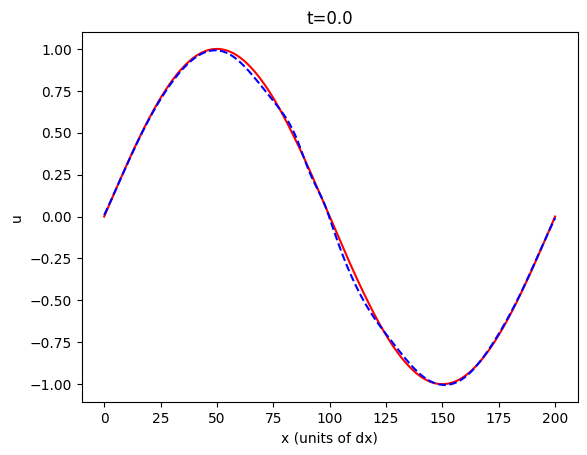

In [108]:
t = 0
plt.plot(f.uList[t], 'r')
plt.plot(S[t], 'b', linestyle = "dashed")
plt.xlabel("x (units of dx)")
plt.ylabel("u")
plt.title(f"t={(t)*0.01}")